# LeBron James: The Offensive Evolution in the NBA

In this notebook we present an analysis of the evolution of LeBron James' offensive game, in terms of shot selection and efficiency, over the course of his NBA career. In particular, we analyze data from the regular seasons from 2003-2004 to 2019-2024, with the aim of understanding how his game has changed over the years and how this has influenced the offensive production of his teams.
To be more specific, we will focus on the following aspects:

- Shot selection: how has LeBron's shot selection evolved over the years? Has he changed the types of shots he takes, such as moving from mid-range to three-point shots?
- Efficiency: how has LeBron's shooting efficiency evolved over the years? Has he become a more efficient scorer?
- Impact on team performance: how has LeBron's offensive evolution influenced the performance of his teams? Has he been able to improve the offensive production of his teams over the years?

First, let's import the necessary libraries and load all the datasets required for the analysis.

In [1099]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from shapely.geometry import Polygon
from matplotlib.lines import Line2D

import warnings

# Ignora tutti i warning
warnings.filterwarnings("ignore")


# Load the data
df_shots = pd.read_pickle("LeBronShots.pickle")

df_advanced = pd.read_pickle("LeBronAdvanced.pickle")

Let's also initialize some variables that will be used throughout the analysis.

In [1100]:
# Seasons arrays
cavs_1 = np.array(['2003-04', '2004-05', '2005-06', '2006-07', '2007-08', '2008-09', '2009-10'])
mia = np.array(['2010-11', '2011-12', '2012-13', '2013-14'])
cavs_2 = np.array(['2014-15', '2015-16', '2016-17', '2017-18'])
lal = np.array(['2018-19', '2019-20', '2020-21', '2021-22', '2022-23', '2023-24'])

# Concatenate seasons arrays
seasons = np.concatenate((cavs_1, mia, cavs_2, lal))

# Initialize discard counts for each zone
discards = {
    'Left Side Mid-Range': 0,
    'Right Side Mid-Range': 0,
    'Center Mid-Range': 0,
    'Left Side Corner 3': 0,
    'Left Side Three Point': 0,
    'Right Side Corner 3': 0,
    'Right Side Three Point': 0,
    'Center Three Point': 0,
    'In The Paint (Non Restricted)': 0,
    'Restricted Area': 0
}

# Initialize lists for each shooting zone
Left_Side_Mid_Range = []
Right_Side_Mid_Range = []
Center_Mid_Range = []
Left_Side_Corner_3 = []
Left_Side_Three_Point = []
Right_Side_Corner_3 = []
Right_Side_Three_Point = []
Center_Three_Point = []
In_The_Paint_Non_Restricted = []
Restricted_Area = []

# Eras labels
eras_label = ['Cleveland Cavs (1)', 'Miami Heat', 'Cleveland Cavs (2)', 'Los Angeles Lakers']

# Shot selection

To analyze LeBron's shot selection over the years, we will look at the distribution of his shot attempts by shot location (restricted area, paint, mid-range, corner 3, ...). We will compare the distribution of shot attempts in different eras to see how LeBron's shot selection has evolved over time.
In order to do this, we will use a self arrenged version of EDU VADILLO kaggle dataset, which contains detailed information about LeBron's shot attempts, including shot location, shot type, and outcome. The dataset can be found here: https://www.kaggle.com/datasets/eduvadillo/lebron-james-career-shots
In this very first part of the analysis we will draw a heatmap of LeBron's shot attempts by shot location for different eras, in order to visualize how his shot selection has evolved over the years.


### NBA Court Chart
To start our analysis, we need to define an NBA court chart, which will serve as the foundation for plotting shot data. Below is a function that creates a basketball court chart using the matplotlib library. This function takes an axis object as input on which the court will be plotted and returns the axis object for further customization.

This function is an adaptation of the one originally provided by Zach Gilbert in his project "Visualizing NBA Shots with py-Goldsberry", which is available https://github.com/bradleyfay/py-Goldsberry/blob/master/docs/Visualizing%20NBA%20Shots%20with%20py-Goldsberry.ipynb.

In [1101]:
#note: this function has benn optimized to plot more than one court at the same time

# Parameters
color = 'black'
lw = 2

def draw_court(ax=None):
    if ax is None:
        ax = plt.gca()

    # Elements of the court
    # Basketball hoop
    hoop = patches.Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Backboard
    backboard = patches.Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # Paint
    paint_lines = patches.Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color, fill=False)
    
    # Free throw top arc
    free_throw = patches.Arc((0, 142.5), 120, 120, theta1=0, theta2=180, linewidth=lw, color=color, fill=False)
    
    # Restricted area
    restricted_area = patches.Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw, color=color)

    # Three point line
    # Side three point lines
    right_corner_side_line = patches.Rectangle((-220, -47.5), 0, 137.5, linewidth=lw, color=color)
    left_corner_side_line = patches.Rectangle((220, -47.5), 0, 137.5, linewidth=lw, color=color)

    # Three point arc
    three_arc = patches.Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw, color=color)

    # Outer lines
    outer_lines = patches.Rectangle((-250, -47.5), 500, 470, linewidth=lw, color=color, fill=False)

    # List of court elements
    court_elements = [hoop, backboard, paint_lines, free_throw, restricted_area, right_corner_side_line, left_corner_side_line, three_arc, outer_lines]

    # Add the elements to the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax


### Area Division Function
Once we have defined the court chart, we can implement a new function to generate the areas into which the court is divided. Specifically, we will divide the court into 10 areas:
- Restricted Area
- In The Paint (Non-RA)
- Mid-Range Left
- Mid-Range Right
- Mid-Range Center
- Left Corner 3
- Right Corner 3
- Three Point Left
- Three Point Right
- Three Point Center

This function utilizes Polygon objects from the shapely library to define specific areas. We start by constructing several polygons using the coordinates of the points that define the vertices of these areas. Then, we employ set operations on these polygons to create the desired areas.

The function returns a dictionary that maps each area to its corresponding polygon object.

In [1102]:
# Function to create arc points
def create_arc_points(radius, start_angle, end_angle, num_points=100):
    theta = np.linspace(np.radians(start_angle), np.radians(end_angle), num_points)
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)
    return np.column_stack((x, y))

# Create arc points
arc_x, arc_y = create_arc_points(237.5, 22, 158).T

# Create restricted area points
restricted_x, restricted_y = create_arc_points(40, 0, 180).T

# Define points for different shooting areas
Arc_points = np.column_stack((arc_x, arc_y))

ThreePointArea_Left_points = [(250, 422.5), (250, 90), (220, 90), (80, 142.5), (120, 422.5)]
ThreePointArea_Center_points = [(80, 142.5), (120, 422.5), (-120, 422.5), (-80, 142.5)]
ThreePointArea_Right_points = [(-250, 422.5), (-250, 90), (-220, 90), (-80, 142.5), (-120, 422.5)]
LeftCornerThree_points = [(220, -47.5), (220, 90), (250, 90), (250, -47.5)]
RightCornerThree_points = [(-220, -47.5), (-220, 90), (-250, 90), (-250, -47.5)]

MidRange_Left_points_Aux = [(120, 422.5), (80, 142.5), (80, -47.5), (220, -47.5), (220, 422.5)]
MidRange_Center_points = [(-80, 142.5), (-120, 422.5), (120, 422.5), (80, 142.5)]
MidRange_Right_points_Aux = [(-120, 422.5), (-80, 142.5), (-80, -47.5), (-220, -47.5), (-220, 422.5)]

Paint_points = [(80, -47.5), (80, 142.5), (-80, 142.5), (-80, -47.5)]

Restricted_Area_points1 = np.column_stack((restricted_x, restricted_y))
Restriced_Area_points2 = [(40, 0), (40, -10), (-40, -10), (-40, 0)]
Restricted_Area_points = np.vstack((Restricted_Area_points1, Restriced_Area_points2))

# Create Polygon objects from points
def create_polygons():
    Arc_Pol = Polygon(Arc_points)
    ThreePointArea_Left_Aux = Polygon(ThreePointArea_Left_points)
    ThreePointArea_Center_Aux = Polygon(ThreePointArea_Center_points)
    ThreePointArea_Right_Aux = Polygon(ThreePointArea_Right_points)
    LeftCornerThree = Polygon(LeftCornerThree_points)
    RightCornerThree = Polygon(RightCornerThree_points)
    MidRange_Left_Aux = Polygon(MidRange_Left_points_Aux)
    MidRange_Center_Aux = Polygon(MidRange_Center_points)
    MidRange_Right_Aux = Polygon(MidRange_Right_points_Aux)
    Paint = Polygon(Paint_points)
    Restricted_Area = Polygon(Restricted_Area_points)

    # Calculate differences to define final areas
    ThreePointArea_Left = ThreePointArea_Left_Aux.difference(Arc_Pol)
    ThreePointArea_Center = ThreePointArea_Center_Aux.difference(Arc_Pol)
    ThreePointArea_Right = ThreePointArea_Right_Aux.difference(Arc_Pol)
    MidRange_Center_Aux1 = MidRange_Center_Aux.difference(ThreePointArea_Center)
    MidRange_Center = MidRange_Center_Aux1.difference(Paint)
    MidRange_Left = MidRange_Left_Aux.difference(ThreePointArea_Left)
    MidRange_Right = MidRange_Right_Aux.difference(ThreePointArea_Right)

    # Create a dictionary with the areas
    areas = {
        'Left Side Mid-Range': MidRange_Left,
        'Right Side Mid-Range': MidRange_Right,
        'Center Mid-Range': MidRange_Center,
        'Left Side Corner 3': LeftCornerThree,
        'Left Side Three Point': ThreePointArea_Left,
        'Right Side Corner 3': RightCornerThree,
        'Right Side Three Point': ThreePointArea_Right,
        'Center Three Point': ThreePointArea_Center,
        'In The Paint (Non Restricted)': Paint,
        'Restricted Area': Restricted_Area
    }
    return areas

Before plotting the shot distribution, we need to perform a calculation to determine the color and opacity for each area of the court, which will provide a clearer visualization of the hottest zones. This involves two key functions:

### Shot Distribution Function
#### Calculate Shot Distribution
This function computes the shot distribution percentage for a given dataset. It takes the dataset as input and returns a dictionary that maps each area to the number of shots attempted in that area.

#### Auxiliary Function: Generate Shot Attempts Dictionary
This function generates a dictionary that maps each area to the number of shots attempted in that area. It takes the dataset and the dictionary of areas as input, and returns the dictionary of shot attempts for each area.

In [1103]:
def shots(data):
    # Calculate the number of shots attempted for each area
    LS_Mid = data[(data.Area == 'Left Side(L)') & (data.Zone == 'Mid-Range')].shape[0]
    RS_Mid = data[(data.Area == 'Right Side(R)') & (data.Zone == 'Mid-Range')].shape[0]
    C_Mid = data[(data.Area == 'Center(C)') & (data.Zone == 'Mid-Range')].shape[0]
    LS_Corner = data[(data.Zone == 'Left Corner 3')].shape[0]
    LS_Three = data[(data.Area == 'Left Side(L)') & (data.Zone == 'Above the Break 3')].shape[0]
    RS_Corner = data[(data.Zone == 'Right Corner 3')].shape[0]
    RS_Three = data[(data.Area == 'Right Side(R)') & (data.Zone == 'Above the Break 3')].shape[0]
    C_Three = data[(data.Area == 'Center(C)') & (data.Zone == 'Above the Break 3')].shape[0]
    Paint = data[(data.Zone == 'In The Paint (Non-RA)')].shape[0]
    Restricted = data[(data.Zone == 'Restricted Area')].shape[0]

    # Create a dictionary with the total number of shots attempted for each area
    attempts = {
        'Left Side Mid-Range': LS_Mid,
        'Right Side Mid-Range': RS_Mid,
        'Center Mid-Range': C_Mid,
        'Left Side Corner 3': LS_Corner,
        'Left Side Three Point': LS_Three,
        'Right Side Corner 3': RS_Corner,
        'Right Side Three Point': RS_Three,
        'Center Three Point': C_Three,
        'In The Paint (Non Restricted)': Paint,
        'Restricted Area': Restricted
    }

    return attempts


So we use the previous function to calculate the shot distribution for each era and then plot the shot distribution for each era.

In [1104]:
def shot_distribution(data, seasons):
    #Calculate Shot Distribution: This function determines the shot distribution percentage for a given dataset.
    #Parameters:
    #data (DataFrame): The dataset containing shot data.
    #seasons (list of strings): List of seasons to filter the dataset.

    #Returns:
    #dict: A dictionary mapping each area to the percentage of shots attempted in that area.

    # Filter the data by the given seasons
    filtered_data = data[data.index.get_level_values('Season').isin(seasons)]

    # Get the total number of shots attempted in the filtered dataset
    total_shots = filtered_data.shape[0]

    # Get the number of shots attempted for each area
    attempts = shots(filtered_data)

    # Calculate the shot distribution percentage for each area
    distribution = {area: (attempts[area] / total_shots * 100) for area in attempts.keys()}

    return distribution


### Calculate Color and Opacity

This function calculates the color and opacity for each area based on the shot distribution. It takes the shot distribution dictionary and the maximum opacity value as inputs and returns a dictionary that maps each area to its corresponding color and opacity value.

In this script, a variable named "max_value" is defined to represent the overall maximum value of the distribution across all areas. This variable is crucial for accurate analysis, enabling effective comparison of shot distributions from different areas. Determining "max_value" involves manually identifying the highest values among the distributions from all areas to ensure precision in the analysis.

In [1105]:
#Here we calculate the shot distribution for each period and define the color scale for the heatmap

# Calculate shot distribution for each period
distribution_cavs1 = shot_distribution(df_shots, cavs_1)
distribution_mia = shot_distribution(df_shots, mia)
distribution_cavs2 = shot_distribution(df_shots, cavs_2)
distribution_lal = shot_distribution(df_shots, lal)

# Calculate the maximum value for the shot distribution
max_value = max(
    max(distribution_cavs1.values()),
    max(distribution_mia.values()),
    max(distribution_cavs2.values()),
    max(distribution_lal.values())
)

print(max_value)

# Calculate the bounds for the color scale
# High percentage
#high = 30.8%
high = 0.68 * max_value

# Medium percentage
#medium = 10%
medium = 0.24 * max_value

# Low percentage
#low = 6.5%
low = 0.15 * max_value

levels = ['very_low', 'low', 'medium', 'high']


43.99333749739746


In [1106]:

col_and_op = { 'Left Side Mid-Range': ['', 0], 'Right Side Mid-Range': ['', 0], 'Center Mid-Range': ['', 0], 'Left Side Corner 3': ['', 0], 'Left Side Three Point': ['', 0],
               'Right Side Corner 3': ['', 0], 'Right Side Three Point': ['', 0], 'Center Three Point': ['', 0], 'In The Paint (Non Restricted)': ['', 0], 'Restricted Area': ['', 0]}


def color_and_opacity(distribution, alpha):

    #calculate the opacity
    for area in distribution:
        opacity = (distribution[area] * alpha) / max_value
        #update the dictionary
        col_and_op[area][1] = opacity

        #calculate the color
        if distribution[area] > high:
            col = 'darkred'
        elif distribution[area] > medium:
            col = 'red'
        elif distribution[area] > low:
            col = 'darkorange'
        else:
            col = 'yellow'
        #update the dictionary
        col_and_op[area][0] = col

    return col_and_op

### Plot Shot Distribution
Now that we have all the necessary functions in place, we can proceed to plot the shot distribution heatmap. Let's try to plot the shot distribution for LeBron's first run in Cleveland (2003-2004 to 2009-2010).

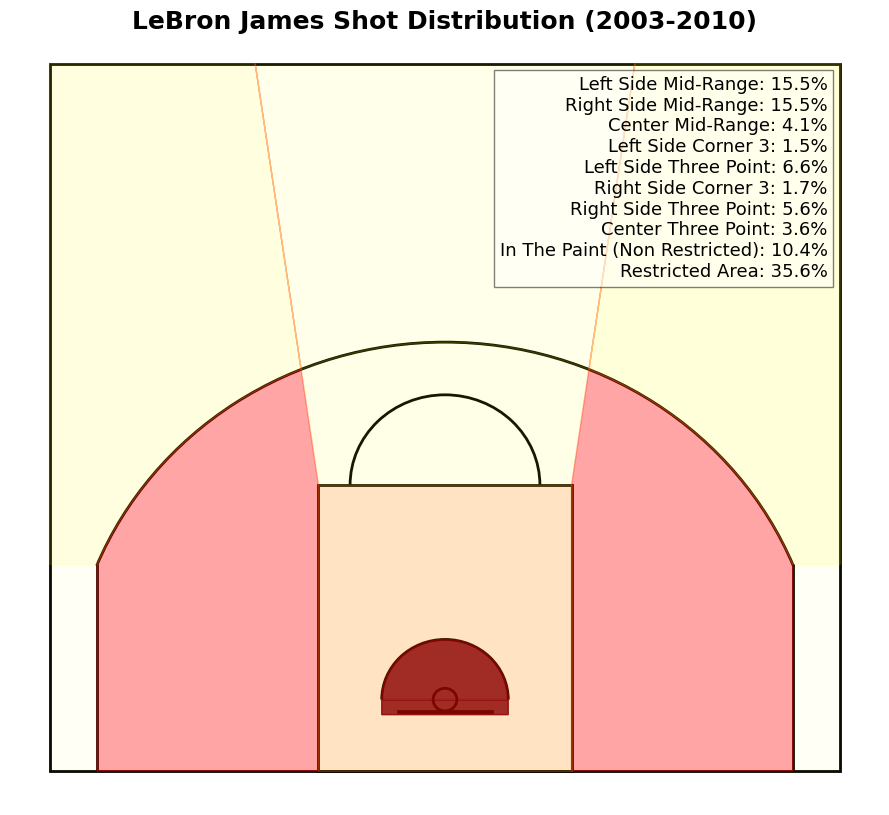

In [1107]:
def plot_shot_distribution(distribution, alpha, title):
    # Calculate colors and opacities
    colore_opacita = color_and_opacity(distribution, alpha)

    # Set the size of the plot
    fig, ax = plt.subplots(figsize=(9,8.25))

    # Plot the court
    draw_court()  # Assuming you have a function `draw_court()` that plots the basketball court

    # Plot the areas
    areas = create_polygons()  # Assuming you have a function `create_polygons()` that creates polygons for each area
    for area in areas:
        plt.fill(*areas[area].exterior.xy, color=colore_opacita[area][0], alpha=colore_opacita[area][1])

    plt.xlim(-275, 275)
    plt.ylim(-70, 440)
    plt.axis('off')

    plt.title(title, fontsize=18, fontweight='bold')

    # Add a legend box with shot distribution information
    text = '\n'.join([f'{area}: {distribution[area]:.1f}%' for area in distribution.keys()])
    plt.text(0.94, 0.95, text, fontsize=13, verticalalignment='top', horizontalalignment='right', transform=ax.transAxes, bbox=dict(edgecolor='black', facecolor='white', alpha=0.5))

    plt.tight_layout()
    plt.show()

# Example usage:
plot_shot_distribution(distribution_cavs1, alpha=1, title='LeBron James Shot Distribution (2003-2010)')


At this stage, we've successfully created a heatmap illustrating LeBron James' shot distribution during his initial stint with the Cleveland Cavaliers. This heatmap visually displays the frequency of shot attempts across various zones on the basketball court, offering valuable insights into LeBron's shot selection during that period. Our next objective is to replicate this process for each distinct phase of LeBron's career in the NBA. This comprehensive approach will allow us to compare and analyze his shot distributions over time, revealing any significant changes or patterns in his shooting tendencies throughout his career.

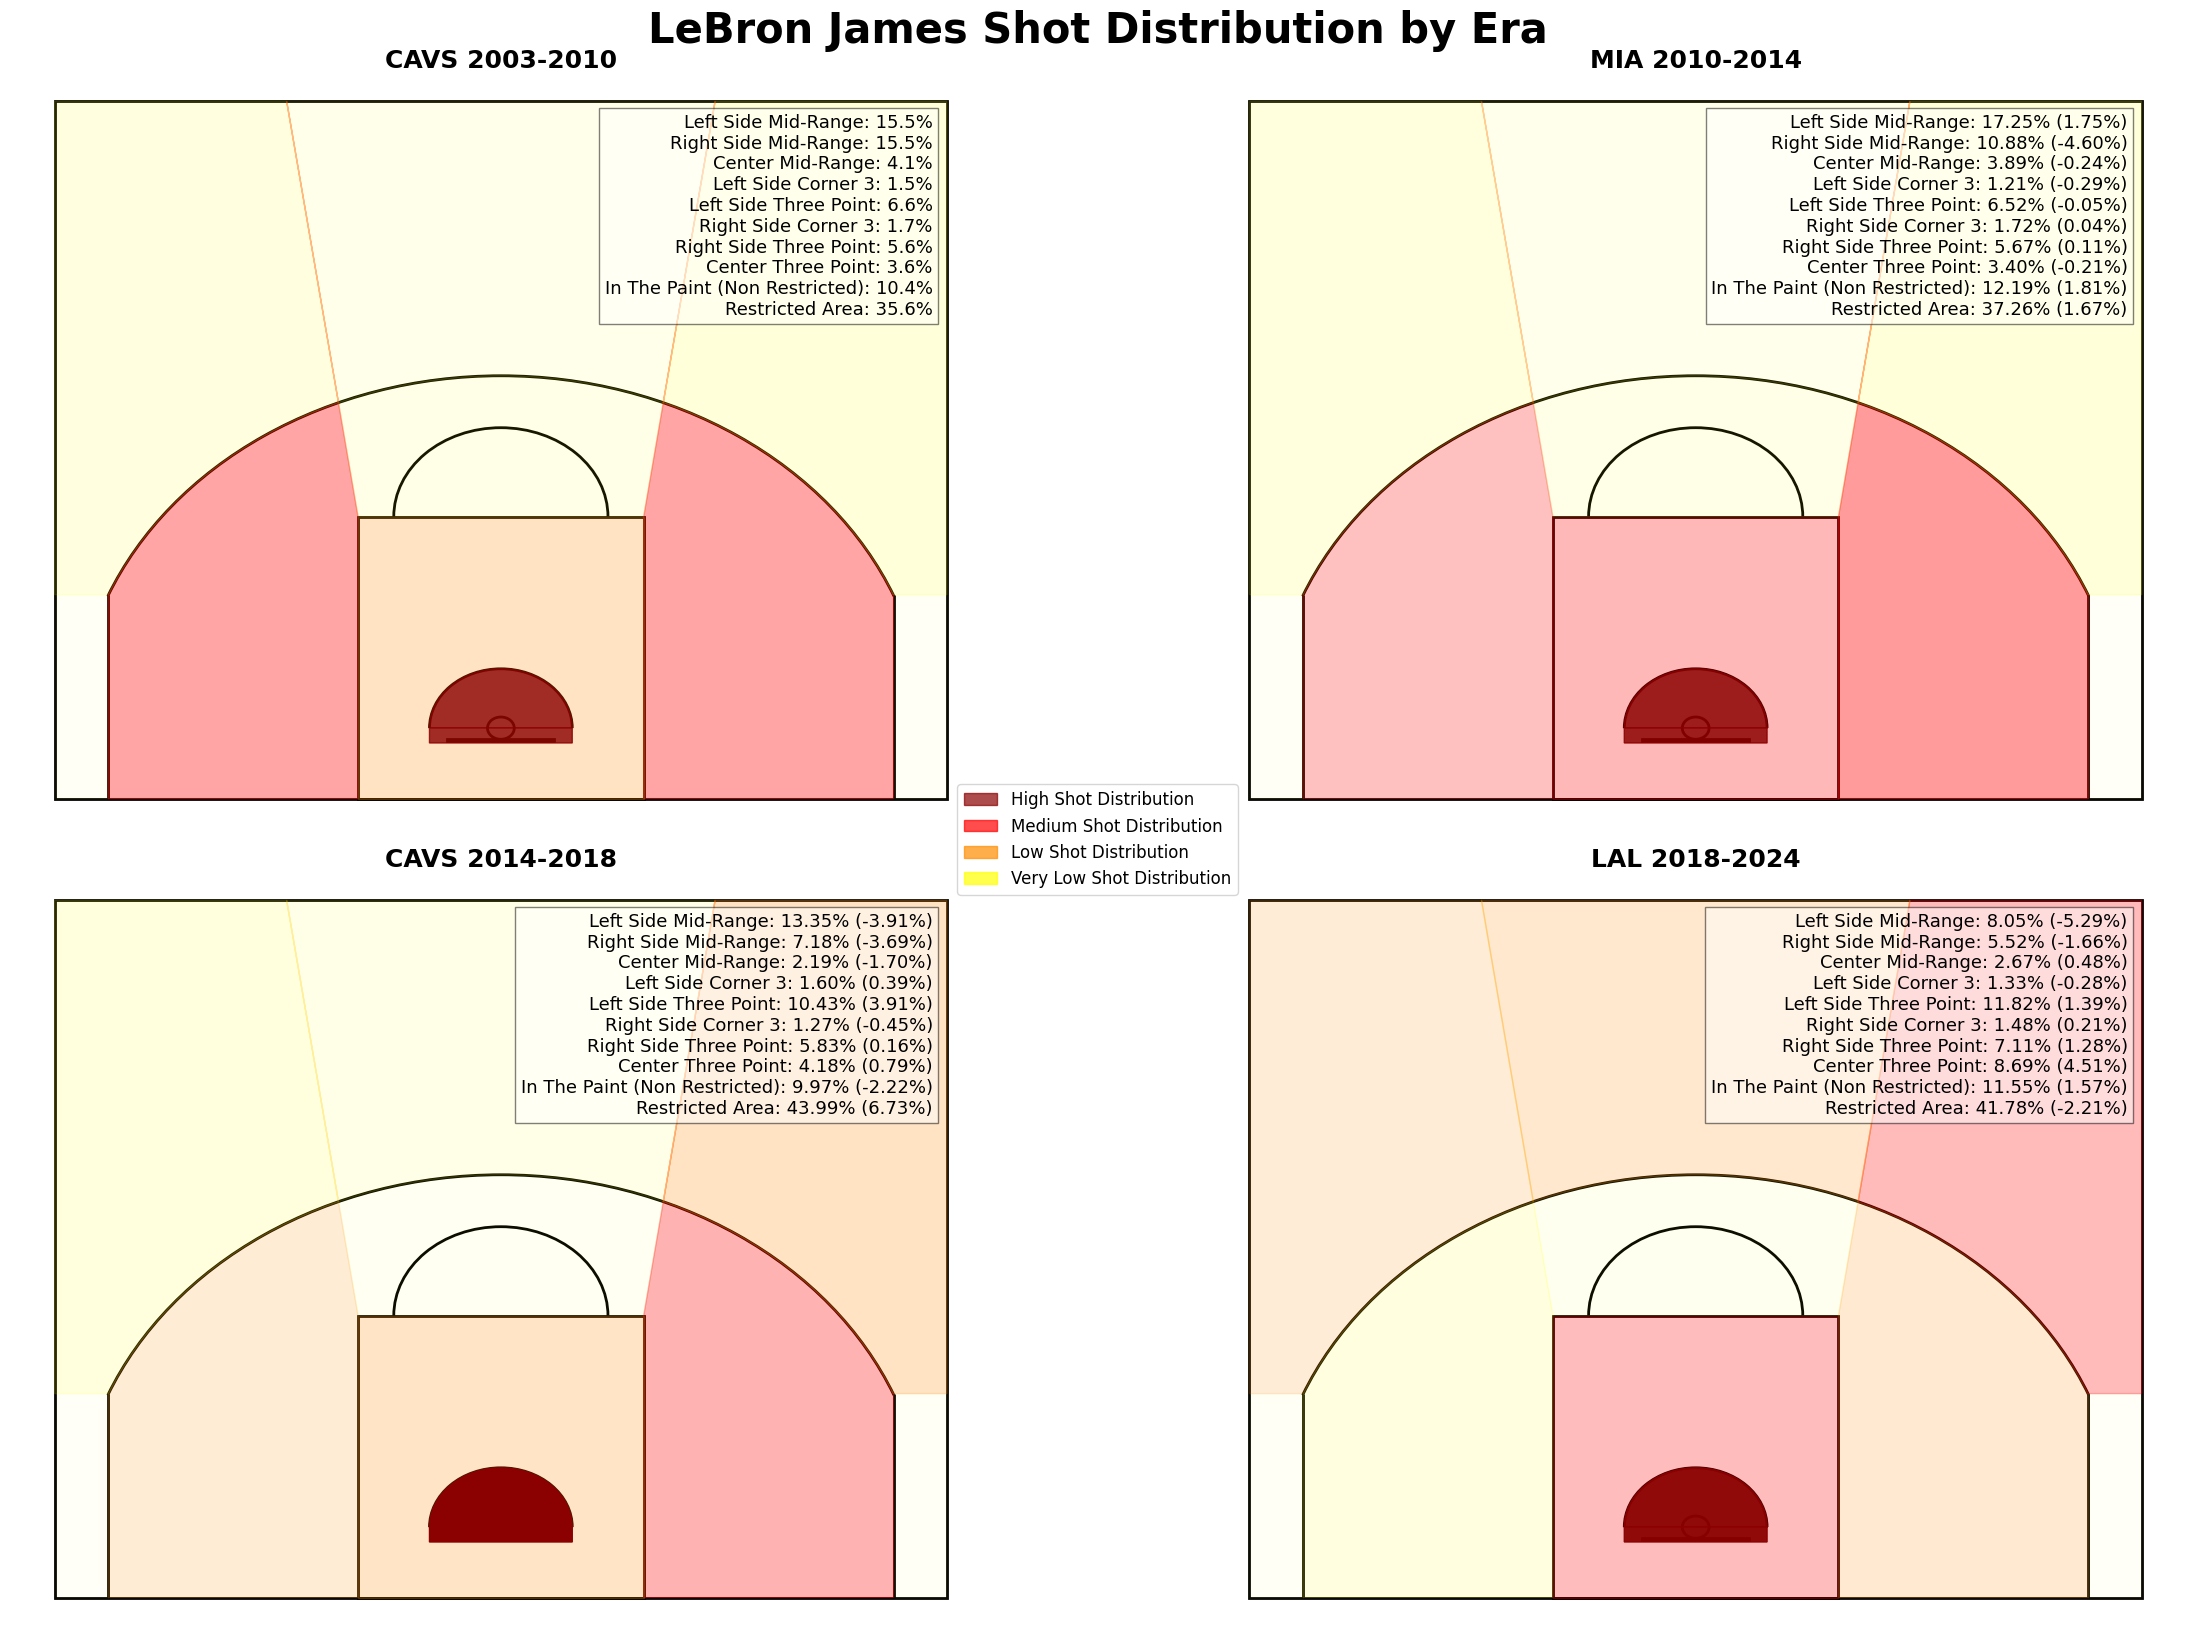

In [1108]:
# Funzione per disegnare il campo e riempire le aree
def draw_and_fill(ax, title, color_opacity):
    draw_court(ax)
    areas = create_polygons()
    for area in areas:
        ax.fill(*areas[area].exterior.xy, color=color_opacity[area][0], alpha=color_opacity[area][1])
    ax.set_xlim(-275, 275)
    ax.set_ylim(-70, 440)
    ax.axis('off')
    ax.set_title(title, fontsize=18, fontweight='bold')

# Funzione per aggiungere la leggenda con la distribuzione dei tiri
def add_legend(ax, distribution, reference_distribution=None):
    if reference_distribution is None:
        text = '\n'.join([f'{area}: {distribution[area]:.1f}%' for area in distribution.keys()])
    else:
        discards = {area: round(distribution[area] - reference_distribution[area], 2) for area in distribution.keys()}
        text = '\n'.join([f'{area}: {distribution[area]:.2f}% ({discards[area]:.2f}%)' for area in distribution.keys()])
    ax.text(0.94, 0.95, text, fontsize=13, verticalalignment='top', horizontalalignment='right', 
            transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='black', alpha=0.5))

# Crea la figura e gli assi
W_subplots = 12  # Larghezza dei subplots
H_subplots = 11  # Altezza dei subplots
width_space = 6   # Spaziatura laterale
height_space = 0.2  # Spaziatura verticale

# Dimensioni del subplot
subplot_width = 9
subplot_height = H_subplots * (subplot_width / W_subplots)

# Dimensioni del plot
fig_width = 2 * subplot_width + width_space
fig_height = subplot_height * 2 + height_space

fig, axs = plt.subplots(2, 2, figsize=(fig_width, fig_height))

# Disegna e riempi i campi per ciascun periodo
draw_and_fill(axs[0, 0], 'CAVS 2003-2010', color_and_opacity(distribution_cavs1, 1))
draw_and_fill(axs[0, 1], 'MIA 2010-2014', color_and_opacity(distribution_mia, 1))
draw_and_fill(axs[1, 0], 'CAVS 2014-2018', color_and_opacity(distribution_cavs2, 1))
draw_and_fill(axs[1, 1], 'LAL 2018-2024', color_and_opacity(distribution_lal, 1))

# Aggiungi le leggende
add_legend(axs[0, 0], distribution_cavs1)
add_legend(axs[0, 1], distribution_mia, distribution_cavs1)
add_legend(axs[1, 0], distribution_cavs2, distribution_mia)
add_legend(axs[1, 1], distribution_lal, distribution_cavs2)

#Add Title
fig.suptitle('LeBron James Shot Distribution by Era', fontsize=30, fontweight='bold', x=0.54)


legend_handles = [
    patches.Patch(color='darkred', alpha=0.7, label='High Shot Distribution'),
    patches.Patch(color='red', alpha=0.7, label='Medium Shot Distribution'),
    patches.Patch(color='darkorange', alpha=0.7, label='Low Shot Distribution'),
    patches.Patch(color='yellow', alpha=0.7, label='Very Low Shot Distribution')
]

# Aggiungi la legenda
#centrata tra i subplot
#params are set manually to fit the legend in the best way
fig.legend(handles=legend_handles, loc='center', fontsize=12, bbox_to_anchor=(0.54, 0.483))

# set width and height between subplots
plt.subplots_adjust(wspace=6, hspace=0.2)

plt.tight_layout()
plt.show()


To conclude this part of the analysis, we can compare the shot distribution for each era side by side to visualize how LeBron's shot selection has evolved over the years. We'll achieve this by plotting a scatter plot of the shot distribution for each era, allowing us to see the changes in his shot selection over time.

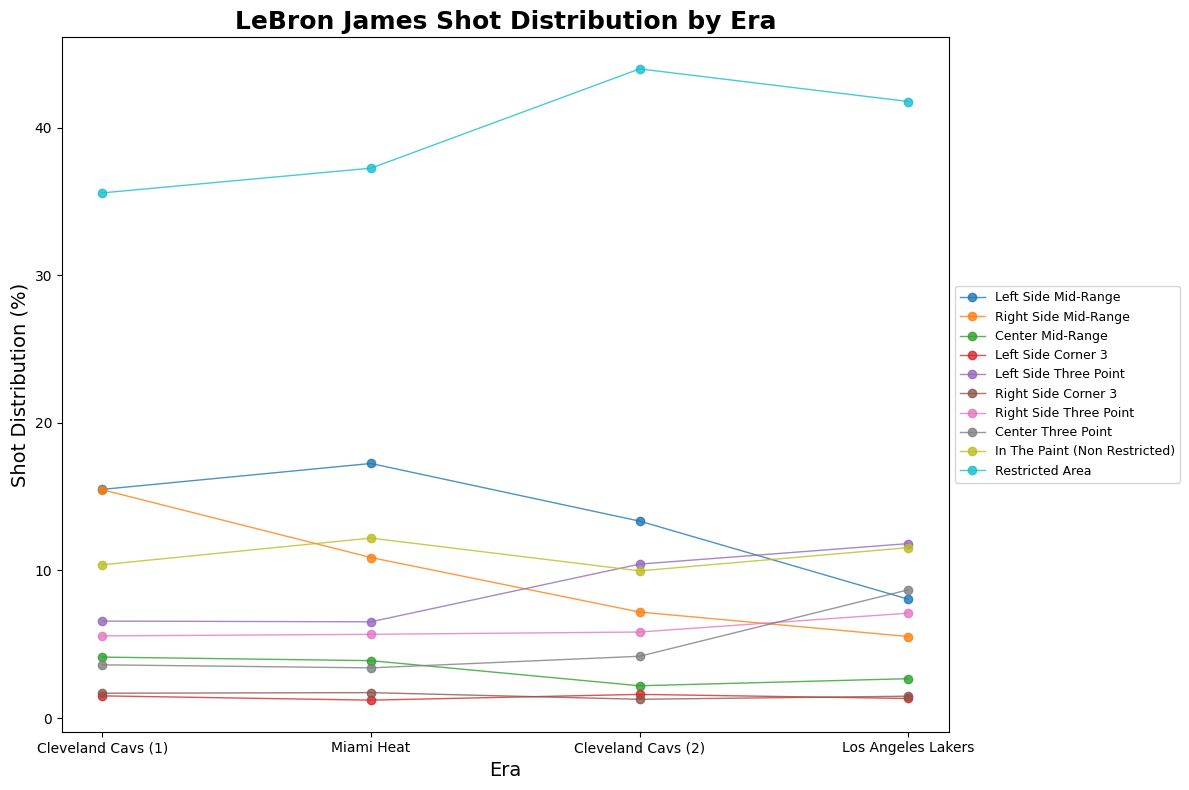

In [1109]:
# Define shot distribution lists for each area
areas = [
    'Left Side Mid-Range', 'Right Side Mid-Range', 'Center Mid-Range',
    'Left Side Corner 3', 'Left Side Three Point', 'Right Side Corner 3',
    'Right Side Three Point', 'Center Three Point',
    'In The Paint (Non Restricted)', 'Restricted Area'
]

# Initialize empty lists for each area
area_distributions = {area: [] for area in areas}

# Append the values to the lists
for era in [distribution_cavs1, distribution_mia, distribution_cavs2, distribution_lal]:
    for area in areas:
        area_distributions[area].append(era[area])

# Set the size of the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the data for each area
for area in areas:
    plt.plot(eras_label, area_distributions[area], marker='o', label=area, linestyle='solid', linewidth=1, alpha=0.8)

# Add labels and title
plt.xlabel('Era', fontsize=14)
plt.ylabel('Shot Distribution (%)', fontsize=14)
plt.title('LeBron James Shot Distribution by Era', fontsize=18, fontweight='bold')

# Add a legend
plt.legend(fontsize=9, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()


LeBron James' shot selection has undergone significant evolution over the years. Initially, he heavily favored mid-range jumpers and shots close to the basket, with fewer attempts from beyond the three-point line. However, as his career has progressed, he has notably increased his volume of three-point attempts, resulting in a more balanced distribution of shots across different areas of the court. Despite his enduring dominance in the paint due to his physical prowess, his improved proficiency in three-point shooting has rendered him an even more versatile and potent offensive threat.

Specifically, there has been a noticeable uptick in LeBron's three-point attempts, especially from the left wing. However, his shooting from the right side has also shown marked improvement. Nevertheless, he continues to favor shooting from the left side of the court, where he appears most comfortable. This preference persists across all stages of his career, underscoring LeBron's consistent affinity for the left side despite the broader diversification of his overall shot selection over time.


# Efficiency

Now that we have analyzed LeBron's shot selection over the years, let's turn our attention to his shooting efficiency. In this section, we will examine LeBron's shooting percentages from different areas of the court and compare them across different eras to see how his efficiency has evolved over time.

The dataset contains information about the outcome of each shot attempt, including whether the shot was made or missed. We can use this data to calculate LeBron's shooting percentages from different areas of the court for each era and analyze how they have changed over time.

### Shooting Efficiency
This function takes the dataset and the eras dictionary as inputs and returns a DataFrame containing LeBron's shooting percentages from each area of the court for each era.

In [1110]:
#Shooting Efficiency

#This function takes the dataset and as inputs and returns a DataFrame containing LeBron's shooting percentages from each area of the court for each era.

#input data: DataFrame, list of strings
#output: DataFrame

def shooting_efficiency(data, seasons):

    #Filter the data by the given seasons

    data = data[data.index.get_level_values('Season').isin(seasons)]

    #Get the total number of shots attempted for each area

    attemps = shots(data)

    #Get the total number of shots made for each area
    #let's use the same function to calculate the number of shots made for each area
    #first we have to filter the data by the shots made

    data = data[data.FG == 1]

    made = shots(data)

    #Create a dictionary with the shooting efficiency for each area
    efficiency = {area: made[area] / attemps[area] * 100 for area in attemps}

    return efficiency


At first glance, a box plot appears to be a suitable way to visualize LeBron's shooting efficiency for each era. Therefore, let's plot a box plot of LeBron's shooting efficiency during his time with the Cleveland Cavaliers from 2003-2004 to 2009-2010. This will help us understand the distribution and variability of his shooting performance during this period.

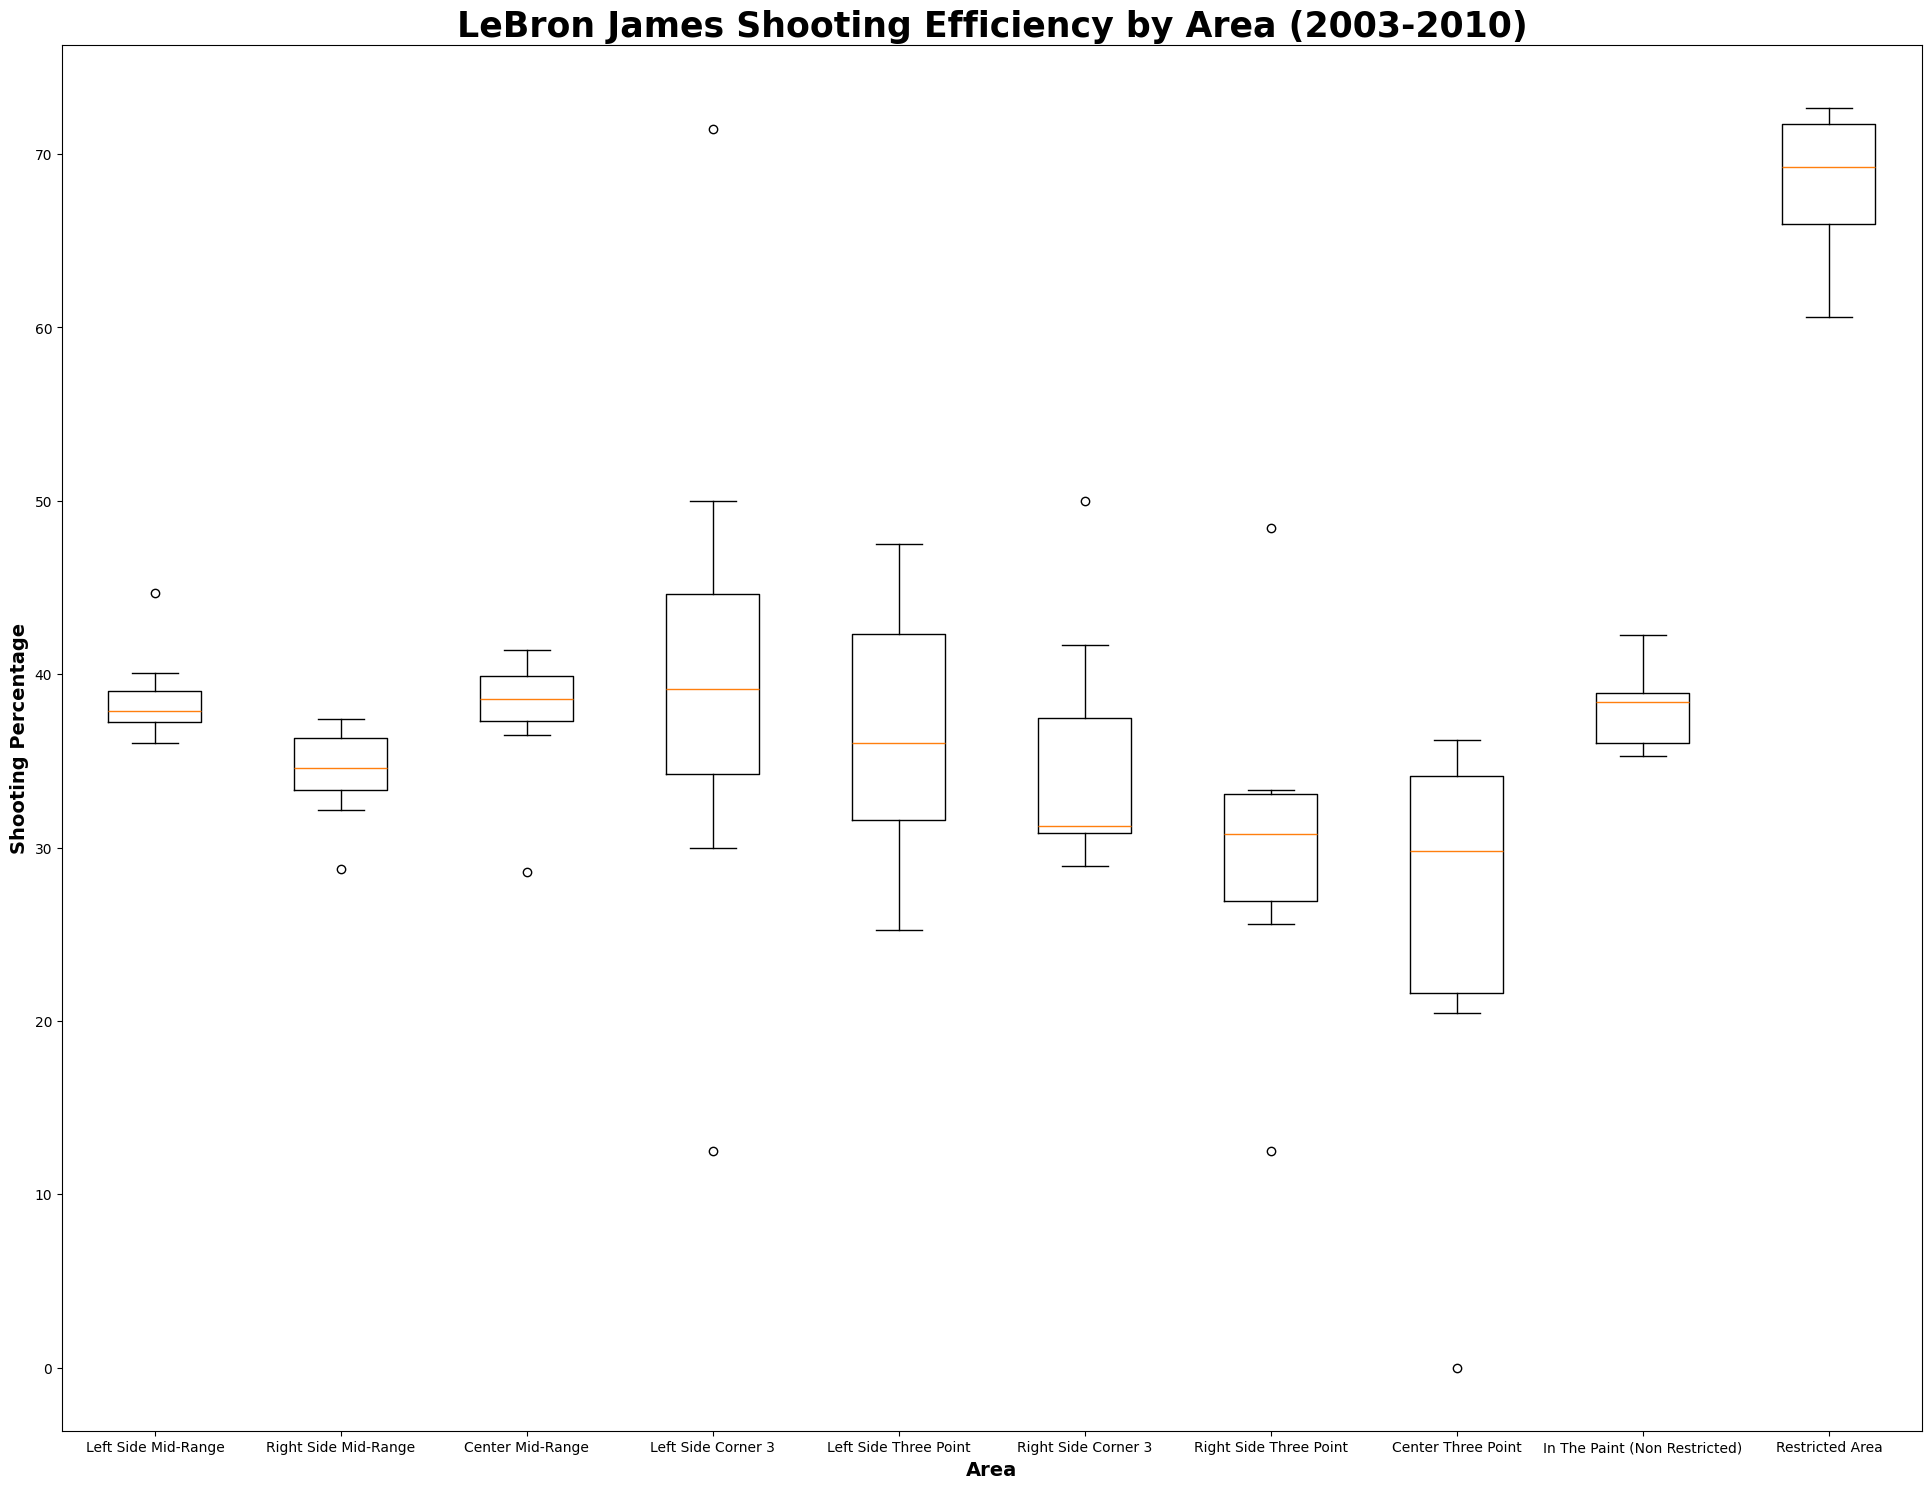

In [1111]:
# Clear lists to ensure they are empty
Left_Side_Mid_Range.clear()
Right_Side_Mid_Range.clear()
Center_Mid_Range.clear()
Left_Side_Corner_3.clear()
Left_Side_Three_Point.clear()
Right_Side_Corner_3.clear()
Right_Side_Three_Point.clear()
Center_Three_Point.clear()
In_The_Paint_Non_Restricted.clear()
Restricted_Area.clear()

# Initialize a dictionary to hold efficiency data
efficiency_data = {
    'Left Side Mid-Range': Left_Side_Mid_Range,
    'Right Side Mid-Range': Right_Side_Mid_Range,
    'Center Mid-Range': Center_Mid_Range,
    'Left Side Corner 3': Left_Side_Corner_3,
    'Left Side Three Point': Left_Side_Three_Point,
    'Right Side Corner 3': Right_Side_Corner_3,
    'Right Side Three Point': Right_Side_Three_Point,
    'Center Three Point': Center_Three_Point,
    'In The Paint (Non Restricted)': In_The_Paint_Non_Restricted,
    'Restricted Area': Restricted_Area
}

# Iterate over seasons and calculate efficiency for each area
for season in cavs_1:
    efficiency = shooting_efficiency(df_shots, [season])
    for area in efficiency_data:
        efficiency_data[area].append(efficiency[area])

# Set the size of the plot
fig, ax = plt.subplots(figsize=(24, 18))

# Plot the data as a boxplot
plt.boxplot(efficiency_data.values(), labels=efficiency_data.keys())

# Add labels and title
plt.xlabel('Area', fontsize=14, fontweight='bold')
plt.ylabel('Shooting Percentage', fontsize=14, fontweight='bold')
plt.title('LeBron James Shooting Efficiency by Area (2003-2010)', fontsize=25, fontweight='bold')

plt.show()


To be fair, this type of plot doesn't clearly illustrate LeBron's shooting efficiency due to the numerous areas it covers. However, it does highlight an important trend: LeBron is very inconsistent from the three-point line, with many outliers in his shooting efficiency. This aligns with the fact that LeBron has never been a great three-point shooter, but rather a player who can make threes when necessary. Further analysis on this aspect will be provided later in the study.

A clearer view of James' shooting efficiency evolution can be obtained by plotting a line graph of his shooting percentages from various distances from the hoop. Specifically, for each era, we will plot two lines: one for his shots from the left side and one for his shots from the right side.

In order to provide that, we will use the following functions:

### Shooting Efficiency by Distance

This function takes a dataframe containing the attempted and made shots of a player, a list of seasons and returns a dataframe with the shooting efficiency of the player for each season.

In [1112]:
#Shooting Efficiency by Distance

#This function takes the dataset and a list of seasons as inputs and returns a list of shooting percentages for each distance range.

#input data: DataFrame, list of strings
#output: list of floats


def shooting_efficiency_distance(data, seasons):
    efficiency = []
    data = data[data.index.get_level_values('Season').isin(seasons)]

    for i in range(0, 30):
        
        attempts = data[data.Distance == i].shape[0]
        made = data[(data.Distance == i) & (data.FG == 1)].shape[0]
        efficiency.append(made / attempts * 100)

    return efficiency

In [1113]:
#some useful constants that will be used to create the distance ranges

efficiency_l = []
efficiency_r = []

distances = np.arange(0, 30)

### Plot distance ranges
This function is designed to visually represent different areas of the basketball court based on their distance from the hoop. It takes an axis object as input and enhances it by plotting the various distance ranges on the court.

In [1114]:
# Define distance ranges and corresponding colors/texts
distances_ranges = np.array([ (0, 3), (3, 15), (8, 23.5), (23.5, 31), (22, 25)])

colors_ranges = np.array(['red', 'blue', 'green', 'purple', 'orange'])

colors_text = np.array(['Restricted Area', 'In The Paint (Non Restricted)', 'Mid-Range', 'Three Point', 'Corner Three'])

# Function to plot shot zones based on distance ranges

def plot_dist(ax):
    for i, (start, end) in enumerate(distances_ranges):
        ax.axvspan(start, end, color=colors_ranges[i], alpha=0.05)
        ax.text((start + end) / 2, 8, colors_text[i], fontsize=7, ha='center', color='black')



Now we can proceed to plot our data. For instance, let's visualize LeBron James' shooting efficiency by distance during his tenure with the Cleveland Cavaliers from 2003-2004 to 2009-2010.

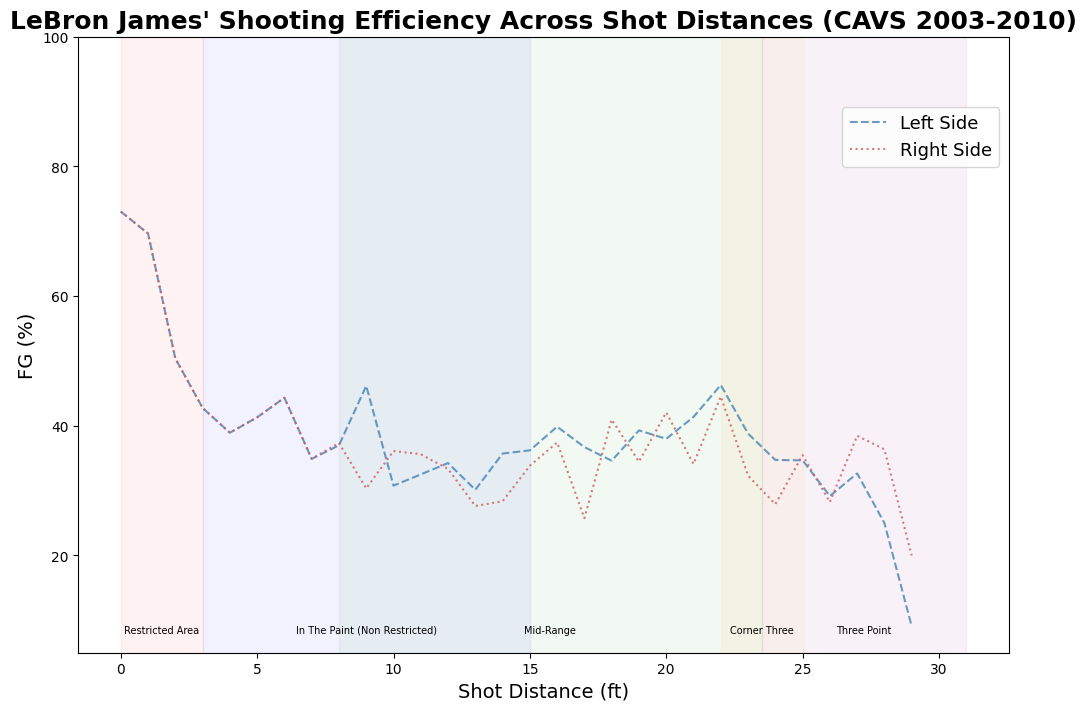

In [1174]:
# scatter plot of correlation between shooting efficiency and shot distance
# plot a line for the left and one for the right side


df_l = df_shots[(df_shots.Area == 'Left Side(L)') | (df_shots.Area == 'Center(C)')]
df_r = df_shots[(df_shots.Area == 'Right Side(R)') | (df_shots.Area == 'Center(C)')]

#calculate the shooting efficiency for the left side
efficiency_l = shooting_efficiency_distance(df_l, cavs_1)

#calculate the shooting efficiency for the right side
efficiency_r = shooting_efficiency_distance(df_r, cavs_1)


#set the size of the plot
fig, ax = plt.subplots(figsize=(12, 8))

#plot the data
plt.plot(range(0, 30), efficiency_l, label='Left Side', color='steelblue', alpha=0.8, linestyle='dashed')
plt.plot(range(0, 30), efficiency_r, label='Right Side', color='indianred', alpha=0.8, linestyle='dotted')

#y axis limits
plt.ylim(5, 100)

#plot the distance ranges
plot_dist(ax)

#add labels and title
plt.xlabel('Shot Distance (ft)', fontsize=14)
plt.ylabel('FG (%)', fontsize=14)
plt.title('LeBron James\' Shooting Efficiency Across Shot Distances (CAVS 2003-2010)', fontsize=18, fontweight='bold')

#add legend
plt.legend( fontsize=13, loc='upper right', bbox_to_anchor=(1, 0.9))

plt.show()


Let's proceed to plot the shooting efficiency for each era side by side, showcasing how LeBron's shooting efficiency has evolved over the years. We will achieve this by creating a line graph where each era represents a line, allowing us to observe the changes in his shooting efficiency across different time periods.

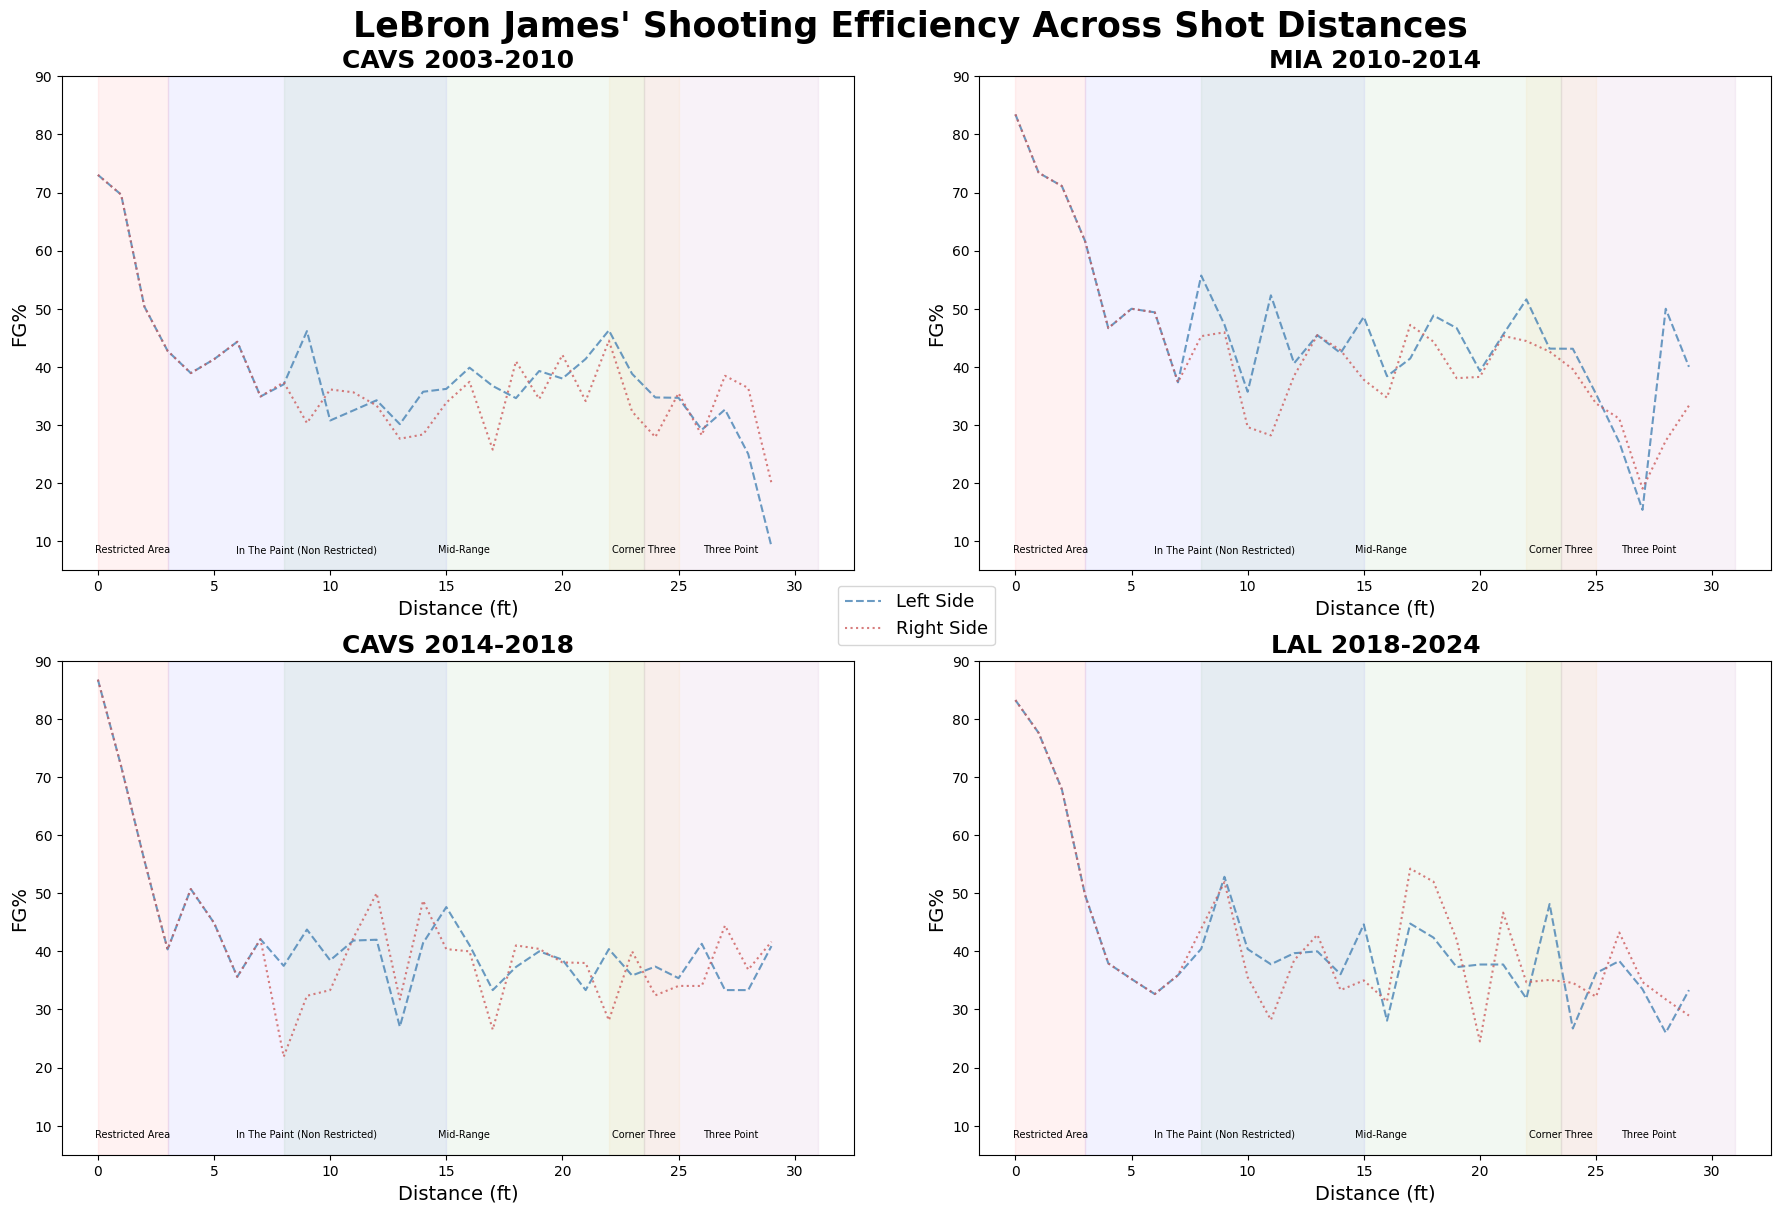

In [1168]:
#Define a function to calculate and plot shooting efficiency
def plot_efficiency(ax, title, team_data, df_shots):
    df_l = df_shots[(df_shots.Area == 'Left Side(L)') | (df_shots.Area == 'Center(C)')]
    df_r = df_shots[(df_shots.Area == 'Right Side(R)') | (df_shots.Area == 'Center(C)')]

    efficiency_l = shooting_efficiency_distance(df_l, team_data)
    efficiency_r = shooting_efficiency_distance(df_r, team_data)

    ax.plot(range(0, 30), efficiency_l, label='Left Side', color='steelblue', alpha=0.8, linestyle='dashed')
    ax.plot(range(0, 30), efficiency_r, label='Right Side', color='indianred', alpha=0.8, linestyle='dotted')

    ax.set_ylim(5, 90)
    plot_dist(ax)
    ax.set_xlabel('Distance (ft)', fontsize=14)
    ax.set_ylabel('FG%', fontsize=14)
    ax.set_title(title, fontsize=18, fontweight='bold')

# Create the figure and axes
fig, axs = plt.subplots(2, 2, figsize=(18.5, 12.33))

# Set width and height between subplots
plt.subplots_adjust(wspace=45, hspace=0.6)

# Plot the shooting efficiency for each era
plot_efficiency(axs[0, 0], 'CAVS 2003-2010', cavs_1, df_shots)
plot_efficiency(axs[0, 1], 'MIA 2010-2014', mia, df_shots)
plot_efficiency(axs[1, 0], 'CAVS 2014-2018', cavs_2, df_shots)
plot_efficiency(axs[1, 1], 'LAL 2018-2024', lal, df_shots)

# Add a legend
fig.legend(['Left Side', 'Right Side'], loc='upper center', fontsize=13, bbox_to_anchor=(0.503, 0.52), bbox_transform=plt.gcf().transFigure)

#Add a title
fig.suptitle('LeBron James\' Shooting Efficiency Across Shot Distances', fontsize=25, fontweight='bold')


plt.tight_layout()

plt.show()


To support our analysis, we can calculate the correlation between LeBron's shooting efficiency and the distances of his shots.

In [1117]:
#This function takes the dataset and a list of seasons as inputs and returns the correlation coefficient between the shot distance and the shooting efficiency for each season.

#input data: DataFrame, list of strings
#output: float

def correlation_distance_efficiency(data, seasons):
    efficiency = []
    efficiency = shooting_efficiency_distance(data, seasons)
    distances = np.arange(0, 30)
    return np.corrcoef(distances, efficiency)[0, 1]

print(correlation_distance_efficiency(df_shots, cavs_1))
print(correlation_distance_efficiency(df_shots, mia))
print(correlation_distance_efficiency(df_shots, cavs_2))
print(correlation_distance_efficiency(df_shots, lal))


#correlazione negativa medio-forte tra distanza e efficienza di tiro

-0.6371182225693237
-0.7746830649191123
-0.5462013896049668
-0.5827765247306257


The graph reveals a clear trend of improvement in LeBron's shooting efficiency over the years, particularly from the three-point line. In the early stages of his career, LeBron faced challenges with three-point shooting, but he has steadily enhanced his skills, becoming a more consistent and reliable shooter from long range. Notably, his efficiency has shown greater stability in the most recent eras, indicating increased reliability from beyond the arc despite a higher volume of attempts.

Another noteworthy observation is LeBron's preference for the left side of the court, where he has consistently demonstrated higher efficiency throughout his career. However, since his return to Cleveland in 2014, his shooting efficiency from the right side has notably improved, suggesting deliberate efforts to develop a more balanced scoring approach.

### 3-Point Shooting Efficiency and Effective Field Goal Percentage Analysis

Based on the insights from the previously plotted boxplot, it's evident that LeBron James has encountered challenges with his three-point shooting efficiency, displaying significant variability in performance over the years.

To delve deeper into this analysis, we will track the evolution of LeBron's three-point shooting efficiency by creating a line graph that illustrates his performance across different eras. This visualization will help us identify trends and changes in his shooting efficiency over time.

Furthermore, another valuable metric to examine is LeBron's Effective Field Goal Percentage (eFG%) progression throughout his career. This metric provides a comprehensive assessment of his shooting efficiency by accounting for the added value of three-point shots. Analyzing LeBron's eFG% across various eras will provide valuable insights into his overall scoring efficiency and illuminate how it has evolved over the course of his career.

To graphically represent this analysis, we will use the following functions:

#### Shooting Efficiency by Season
This function calculates a player's shooting efficiency for each season based on the provided dataset. It returns a DataFrame containing the shooting efficiency for each season.

#### Calculate Effective Field Goal Percentage
This function calculates the Effective Field Goal Percentage (eFG%) for a player based on their shooting data. It takes the dataset as input and returns a DataFrame containing the eFG% for each season. The eFG% formula is defined as follows:

$$
  eFG\% = \frac{FGM + 0.5 * 3P\_made}{FGA}
$$


In [1118]:
#shooting efficiency by season behind the arc

#This function takes the dataset and a list of seasons as inputs and returns a list of shooting percentages for each season

#input data: DataFrame
#output: list of floats

def shooting_efficiency_season(data, seasons):
    efficiency = []

    for season in seasons:
        attempts = data[data.index.get_level_values('Season') == season].shape[0]
        made = data[(data.index.get_level_values('Season') == season) & (data.FG == 1)].shape[0]
        efficiency.append(made / attempts * 100)

    return efficiency

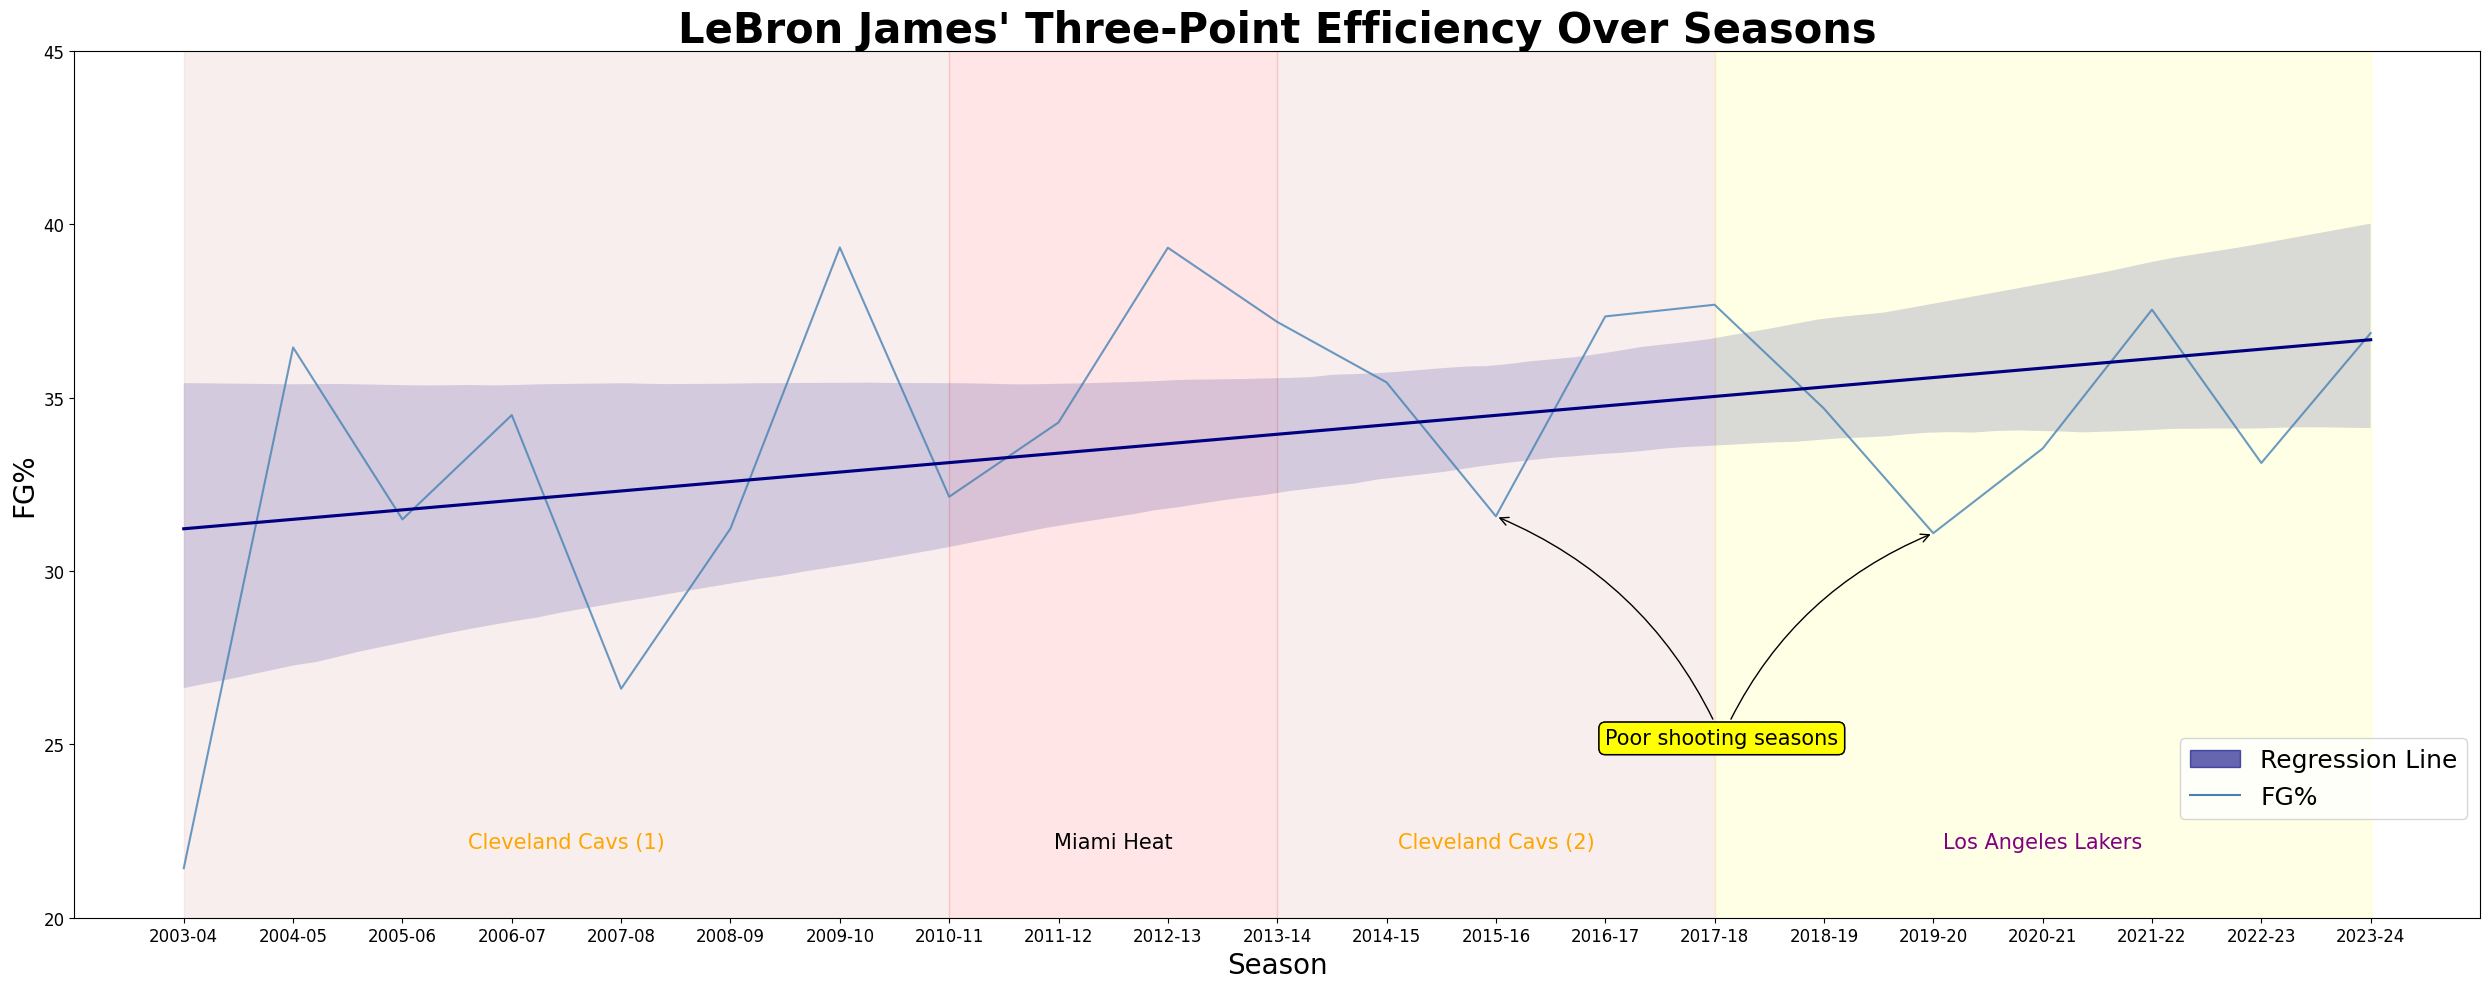

In [1166]:
# Clear lists for shooting efficiency
efficiency_l.clear()
efficiency_r.clear()

# Create numeric seasons list
seasons_numeric = list(range(0, 21))

# Filter data for above the break 3 shots
df_threes = df_shots[df_shots.Zone == 'Above the Break 3']

# Calculate shooting efficiency for above the break 3 shots
efficiency = shooting_efficiency_season(df_threes, seasons)

# Define eras and their respective plot areas with colors and text
eras = [
    ('Cleveland Cavs (1)', 0, 7, 'indianred'),
    ('Miami Heat', 7, 10, 'red'),
    ('Cleveland Cavs (2)', 10, 14, 'indianred'),
    ('Los Angeles Lakers', 14, 20, 'yellow')
]
text_colors = ['orange', 'black', 'orange', 'purple']

# Set the size of the plot
fig, ax = plt.subplots(figsize=(25, 10))
plt.ylim(20, 50)

# Plot the data for three-point shooting efficiency
plt.plot(seasons, efficiency, label='Three Point', color='steelblue', alpha=0.8, linestyle='-')

#text size on axes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


# Plot shaded areas and labels for each era
for (era, start, end, color), text_color in zip(eras, text_colors):
    plt.fill_between([start, end], 0, 100, color=color, alpha=0.1)
    plt.text((start + end) / 2, 22, era, fontsize=15, ha='center', color=text_color)

# Add labels and title
plt.xlabel('Season', fontsize=20)
plt.ylabel('FG%', fontsize=20)
plt.title('LeBron James\' Three-Point Efficiency Over Seasons', fontsize=30, fontweight='bold')


# Annotate poor shooting seasons
annotations = [
    {'text': 'Poor shooting seasons', 'xy': (12, efficiency[12]), 'xytext': (13, 25), 'rad': 0.2},
    {'text': 'Poor shooting seasons', 'xy': (16, efficiency[16]), 'xytext': (13, 25), 'rad': -0.2}
]

for annotation in annotations:
    plt.annotate(
        annotation['text'], xy=annotation['xy'], xytext=annotation['xytext'], fontsize=15,
        arrowprops=dict(arrowstyle="->", connectionstyle=f"arc3,rad={annotation['rad']}", color='black'),
        bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='yellow')
    )

# Plot regression line using seaborn
sns.regplot(x=seasons_numeric, y=efficiency, scatter=False, ax=ax, line_kws={"color": "navy"})

#Add Legend for FG% and regression line
legend_handles = [
    patches.Patch(color='navy', label='Regression Line', alpha=0.6),
    Line2D([0], [0], color='steelblue', label='FG%')
    ]

ax.legend(handles=legend_handles, loc='lower right', fontsize=18, bbox_to_anchor=(1, 0.1))

#set lim
plt.ylim(20, 45)

plt.tight_layout()

plt.show()


In [1120]:
#Effective Field Goal Percentage

#efg = fg + 0.5 * threes_made / attemps

#This function takes the dataset and a list of seasons as inputs and returns a list of effective field goal percentages for each season.

#input data: DataFrame, list of strings
#output: list of floats

def calculate_efg(data, seasons):
    efg = []

    for season in seasons:
        df_season = data[data.index.get_level_values('Season') == season]
        fg = df_season[df_season.FG == 1].shape[0]
        threes_made = df_season[(df_season.FG == 1) & (df_season.Zone == 'Above the Break 3')].shape[0]
        attemps = df_season.shape[0]
        efg.append((fg + 0.5 * threes_made) / attemps * 100)

    return efg

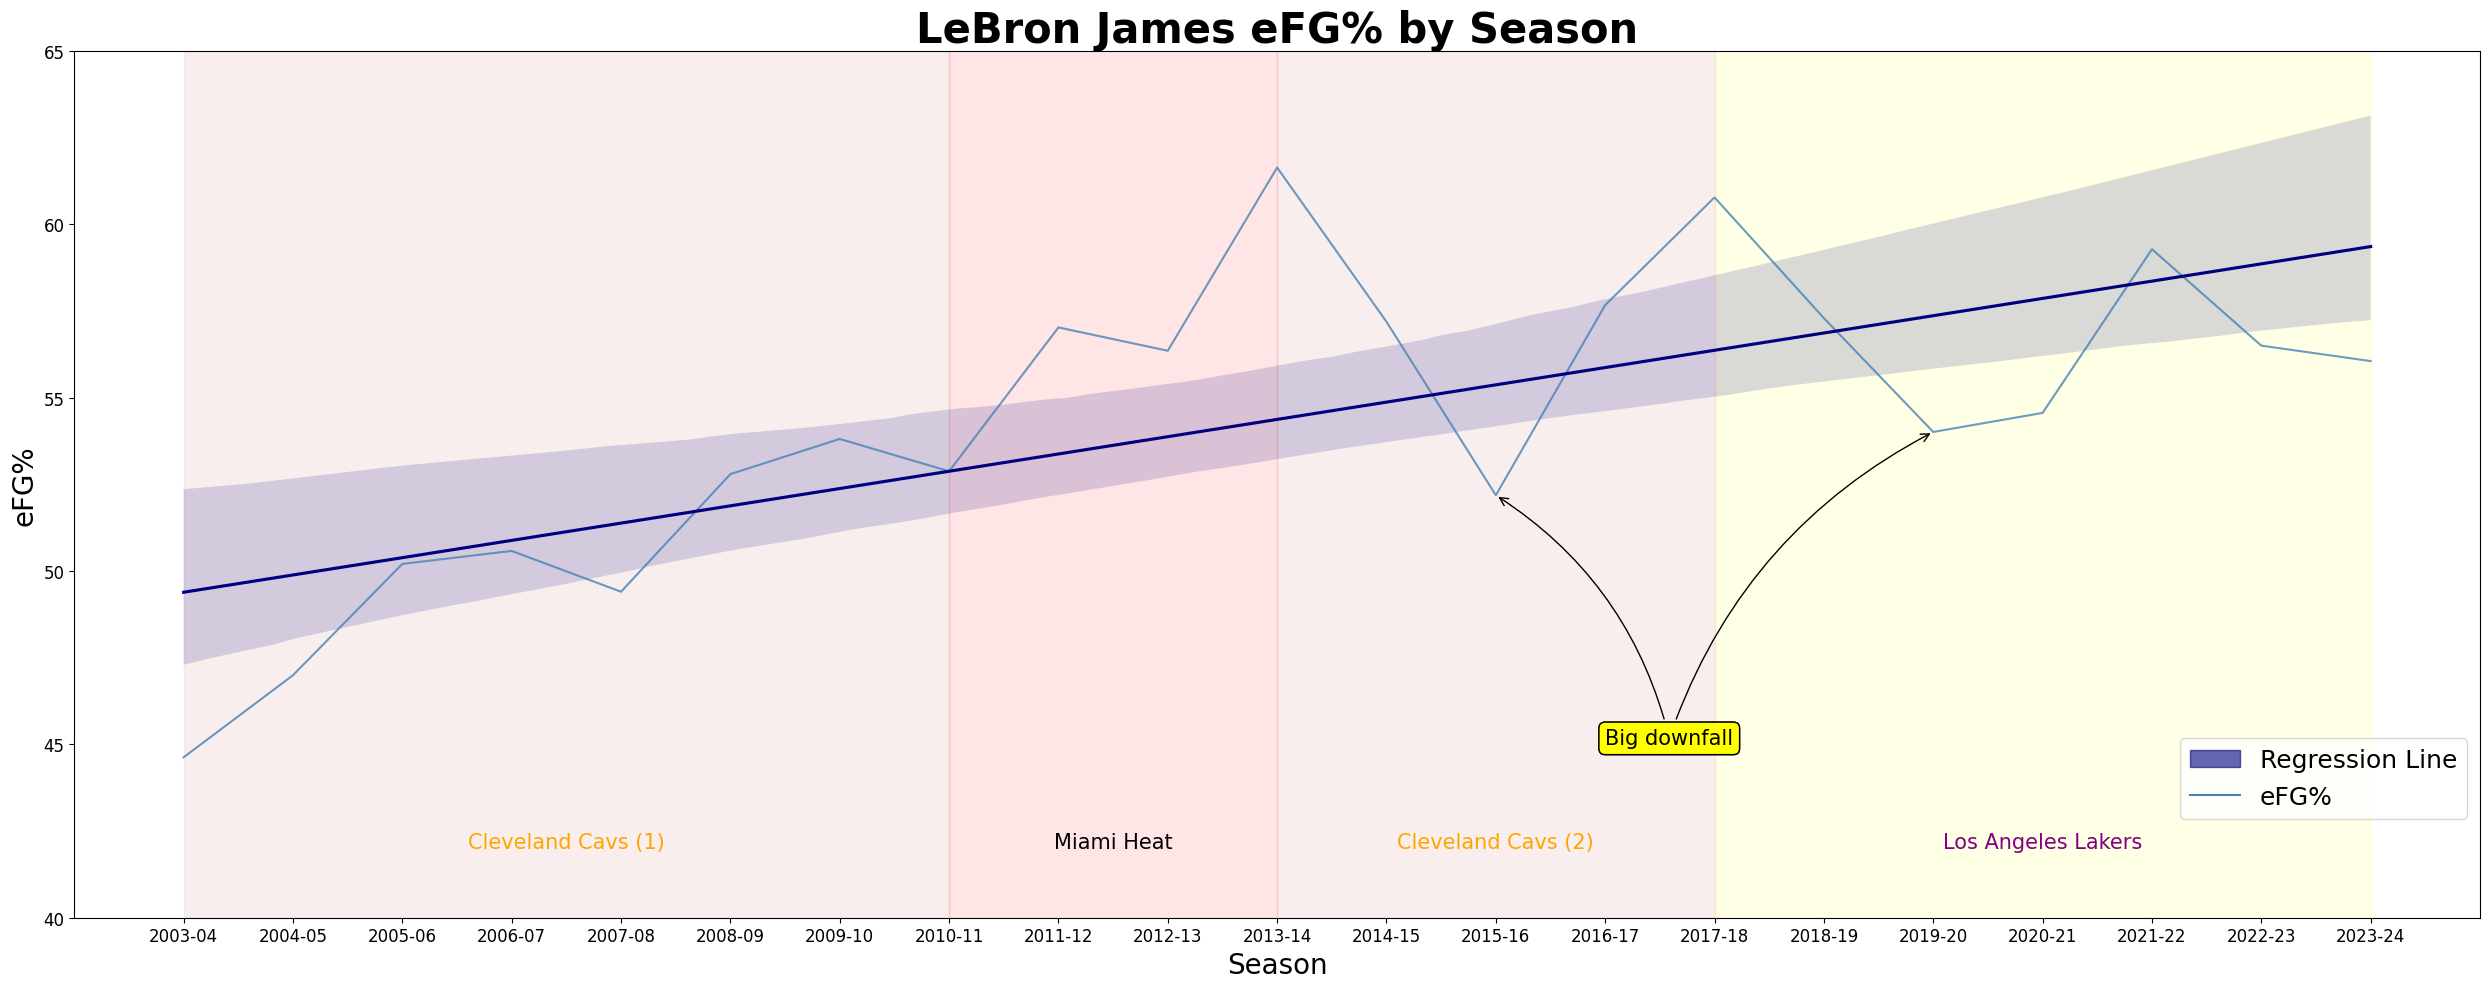

In [1160]:
# Supponiamo che la funzione calculate_efg sia già definita e restituisca i dati necessari
efg = calculate_efg(df_shots, seasons)  # Utilizziamo range(0, 20) per rappresentare le stagioni

# Converti range(0, 20) in una lista di numeri interi
seasons_numeric = list(range(0, 21))

# Imposta la dimensione del grafico
fig, ax = plt.subplots(figsize=(25, 10))

# Limiti dell'asse y
plt.ylim(40, 75)

# Plot the data for effective field goal percentage
plt.plot(seasons, efg, label='Effective Field Goal Percentage', color='steelblue', alpha=0.8, linestyle='-')

#set the size of the text on the axes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Define eras and their respective plot areas with colors and text
eras = [
    ('Cleveland Cavs (1)', 0, 7, 'indianred'),
    ('Miami Heat', 7, 10, 'red'),
    ('Cleveland Cavs (2)', 10, 14, 'indianred'),
    ('Los Angeles Lakers', 14, 20, 'yellow')
]
text_colors = ['orange', 'black', 'orange', 'purple']

# Plot shaded areas and labels for each era
for (era, start, end, color), text_color in zip(eras, text_colors):
    plt.fill_between([start, end], 0, 100, color=color, alpha=0.1)
    plt.text((start + end) / 2, 42, era, fontsize=15, ha='center', color=text_color)


# Annotate poor shooting seasons
annotations = [
    {'text': 'Big downfall', 'xy': (12, efg[12]), 'xytext': (13, 45), 'rad': 0.2},
    {'text': 'Big downfall', 'xy': (16, efg[16]), 'xytext': (13, 45), 'rad': -0.2}
]

for annotation in annotations:
    plt.annotate(
        annotation['text'], xy=annotation['xy'], xytext=annotation['xytext'], fontsize=15,
        arrowprops=dict(arrowstyle="->", connectionstyle=f"arc3,rad={annotation['rad']}", color='k'),
        bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='yellow')
    )

# Plot regression line using seaborn
sns.regplot(x=seasons_numeric, y=efg, scatter=False, ax=ax, line_kws={"color": "navy"})

#Add Legend for efg% and regression line
legend_handles = [
    patches.Patch(color='navy', label='Regression Line', alpha=0.6),
    Line2D([0], [0], color='steelblue', label='eFG%')
    ]

ax.legend(handles=legend_handles, loc='lower right', fontsize=18, bbox_to_anchor=(1, 0.1))


#set lim
plt.ylim(40, 65)

# Add labels and title
plt.xlabel('Season', fontsize=20)
plt.ylabel('eFG%', fontsize=20)
plt.title('LeBron James eFG% by Season', fontsize=30, fontweight='bold')

plt.tight_layout()

plt.show()


As we can see from the graphs, LeBron's three-point shooting efficiency has improved significantly over the years, with a noticeable uptick in the most recent eras. This improvement is reflected in his Effective Field Goal Percentage (eFG%), which has also shown a positive trend, indicating enhanced scoring efficiency. However, we also notice that his shooting percentage is very inconsistent, with many outliers in his shooting efficiency. This aligns with the fact that LeBron isn't a natural three-point shooter but has rather built his shooting skills throughout his career.

His inconsistency in three-point shooting is also reflected in his eFG%, which shows high variability in his shooting efficiency over the years. In particular, the 2015-16 and 2019-20 seasons show a significant downfall in his shooting efficiency, consistent with the previous analysis.

# Impact on Team Performance


Finally, we will investigate how LeBron James' offensive evolution has influenced his teams' performance. This involves analyzing the offensive production of the teams LeBron has played for over the years and examining how his contributions have impacted their overall success.

Our first visualization will be a line graph illustrating the progression of the Offensive Rating (ORtg) of LeBron's teams over time. ORtg is a metric that estimates the number of points a team scores per 100 possessions, offering insights into the team's offensive efficiency. By examining changes in ORtg across different years, we can evaluate the impact of LeBron's offensive development on his teams' overall performance.

In addition to the ORtg for each season, we will also plot the league average ORtg for comparison. This will provide context, allowing us to see how the teams' offensive performance stacks up against the league average and highlight any significant deviations.



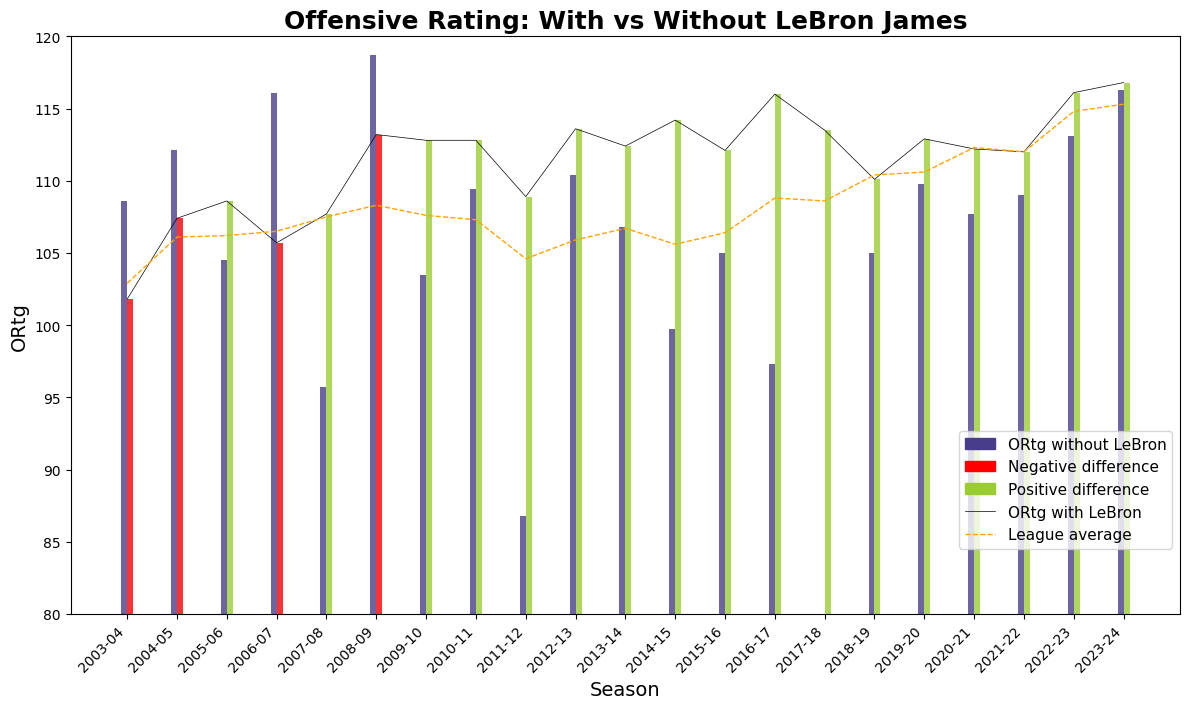

In [1150]:
# Bar color function
# input: val (float): The value to determine the color for
# output: str: The color for the bar

def color_bar(val):
    return 'red' if val < 0 else 'yellowgreen'

# Bar plot function

# input: DataFrame, list of strings
# output: None
def ofr_barPlot(data, seasons):
    # Filter the data by the given seasons
    data = data[data.index.get_level_values('Season').isin(seasons)]

    # Get the average offensive rating without LeBron James
    off_rating_without = data['OFR_T'].values

    # Get the average offensive rating with LeBron James
    off_rating_with = data['OFR_L'].values

    # Set the size of the plot
    fig, ax = plt.subplots(figsize=(12, 7.2))

    # Set the positions of the bars
    x = np.arange(len(seasons))

    # Set the width of the bars
    width = 0.12

    # Plot bars for OFR without LeBron
    ax.bar(x - width/2, off_rating_without[:len(x)], color='darkslateblue', alpha=0.8, width=width)

    # Plot bars for OFR with LeBron
    ax.bar(x + width/2, off_rating_with[:len(x)], color=[color_bar(val) for val in off_rating_with[:len(x)] - off_rating_without[:len(x)]], alpha=0.8, width=width)

    ax.plot(seasons, off_rating_with[:len(seasons)], color='black', linestyle='-', linewidth=0.5)

    ax.plot(seasons, data['LEAGUE_OFR'], color='orange', linestyle='--', linewidth=1)

    # Set the x-axis labels
    ax.set_xticks(x)
    ax.set_xticklabels(seasons, fontsize=10, rotation=45, ha='right')

    ax.set_ylim(80, 120)

    # Add labels and title
    ax.set_xlabel('Season', fontsize=14)
    ax.set_ylabel('ORtg', fontsize=14)
    ax.set_title('Offensive Rating: With vs Without LeBron James', fontsize=18, fontweight='bold')

    # Add a legend
    legend_handles = [
        patches.Patch(color='darkslateblue', label='ORtg without LeBron'),
        patches.Patch(color='red', label='Negative difference'),
        patches.Patch(color='yellowgreen', label='Positive difference'),
        Line2D([0], [0], color='black', linestyle='-', linewidth=0.5, label='ORtg with LeBron'),
        Line2D([0], [0], color='orange', linestyle='--', linewidth=1, label='League average')
    ]

    ax.legend(handles=legend_handles, loc='lower right', fontsize=11, bbox_to_anchor=(1, 0.1))

ofr_barPlot(df_advanced, seasons)

plt.tight_layout()

plt.show()


The plot shows a clear trend of improvement in the Offensive Rating (ORtg) of LeBron's teams over the years, indicating enhanced offensive efficiency and productivity. Notably, the teams' ORtg consistently surpasses the league average, underscoring LeBron's significant impact on his teams' offensive performance.

Another key observation is that, except for the first few years of his career, the presence of LeBron James has consistently elevated his teams' offensive output, with notable spikes in ORtg during his tenure. This trend highlights LeBron's ability to drive offensive success and enhance his teams' scoring capabilities, resulting in improved overall performance.

To gain more insight into his impact on offensive performance, we can calculate the correlation between LeBron's shooting efficiency and his teams' Offensive Rating (ORtg) to determine the relationship between his individual performance and the team's offensive success. Additionally, we can calculate the correlation between LeBron's effective field goal percentage (eFG) and his teams' Offensive Rating (ORtg) to further explore the impact of his three-point shooting on team performance.

A great way to visualize this is to plot a kernel density estimation (KDE) plot to illustrate the relationship between LeBron's shooting efficiency and his teams' Offensive Rating (ORtg). This plot will provide insights into the correlation between LeBron's individual performance and his teams' offensive success, highlighting any patterns or trends in the data.

KDE plots are useful for visualizing the distribution of two variables and identifying potential relationships between them. An elongated shape of the area along the main diagonal of the graph indicates a positive correlation between the variables, while an elongated shape in the opposite direction indicates a negative correlation. Furthermore, the density of points in certain areas of the graph can suggest the presence of clusters or specific patterns. Finally, the Gaussians overlaid on the data provide an estimate of the data distribution and the relationships between the variables.

In [1123]:
# Correlation between OFR_L and time
correlation_ofr_l = np.corrcoef(df_advanced['OFR_L'], seasons_numeric)[0, 1]

# Correlation between LEAGUE_OFR and time
correlation_league_ofr = np.corrcoef(df_advanced['LEAGUE_OFR'], seasons_numeric)[0, 1]

#correlation between OFR_L and efg

correlation_ofr_l_efg = np.corrcoef(df_advanced['OFR_L'], efg)[0, 1]


print(correlation_ofr_l)
print(correlation_league_ofr)
print(correlation_ofr_l_efg)

0.7351854328786415
0.8257438024432494
0.7068172799180411


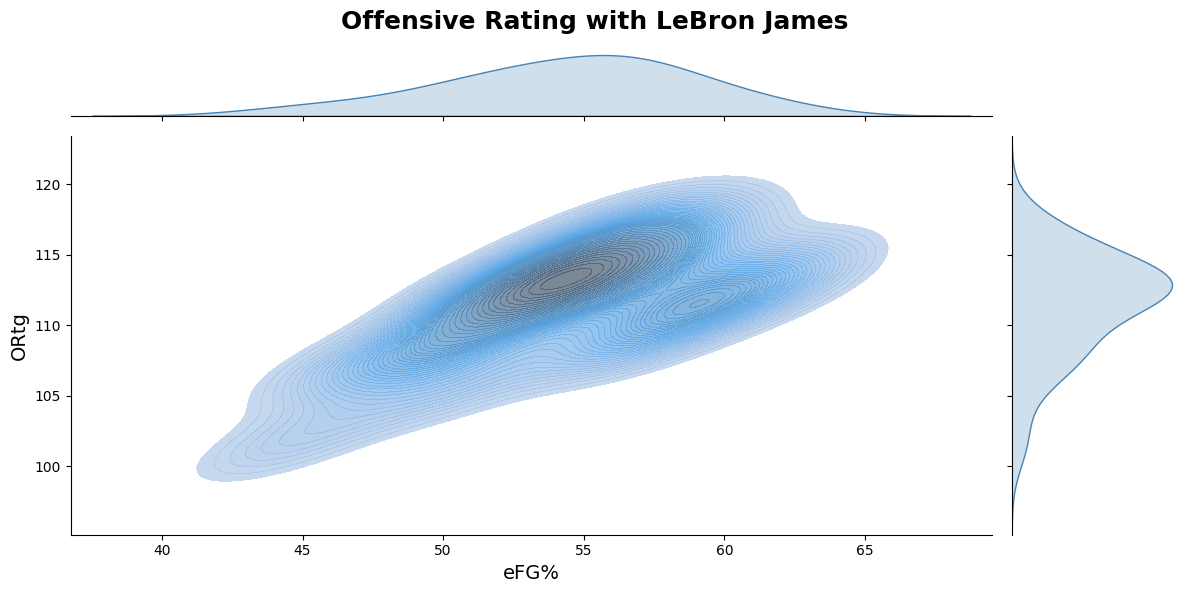

In [1132]:
#plot efg and ofr_l

# Reset index and drop NaN values
df2 = df_advanced.reset_index()

# Create joint plot with KDE and data points
plot = sns.jointplot(x=efg, y=df2['OFR_L'], kind='kde', color='steelblue', fill=True, s=100, alpha=0.7, n_levels=50)

# Set figure size
plot.figure.set_figwidth(12)

# Set axis labels and title
plot.set_axis_labels('Effective Field Goal Percentage', 'Offensive Rating (OFR)', fontsize=14)
plot.figure.suptitle('Offensive Rating Analysis with LeBron James and Effective Field Goal Percentage', fontsize=18, fontweight='bold')

# Add labels and title
plot.set_axis_labels('eFG%', 'ORtg', fontsize=14)
plot.figure.suptitle('Offensive Rating with LeBron James', fontsize=18, fontweight='bold')



plt.tight_layout()

plt.show()


In [1127]:
#calculate USG mean
usg_mean = df_advanced['USG'].mean()

print("Lebron James' average usage: ", usg_mean)

Lebron James' average usage:  31.576190476190472


As we can see from the KDE plot, there is a clear positive correlation between LeBron's shooting efficiency and his teams' Offensive Rating (ORtg). The elongated shape along the main diagonal indicates a strong relationship between the two variables, suggesting that LeBron's individual shooting efficiency has a significant impact on his teams' offensive success. This correlation underscores the importance of LeBron's scoring efficiency in driving his teams' offensive performance and overall success.

The primary explanation for this correlation lies in LeBron's high Usage Rate, which indicates the percentage of team plays involving him while he is on the court. A high Usage Rate implies that the player is responsible for a large proportion of the team's offensive actions, directly influencing overall efficiency and production. In this case, the positive correlation between LeBron's efficiency and his teams' Offensive Rating (ORtg) suggests that his individual contribution is a significant factor in determining the team's offensive success. Notably, LeBron ranks 9th all-time in this statistic with an average Usage Rate of 31.58%. Considering his advanced age compared to other players on the list, this is a particularly remarkable achievement.

The Usage Rate is calculated as follows:

$$
    \text{Usage Rate} = 100 \times \frac{(\text{Player’s Field Goal Attempts} + 0.44 \times \text{Player’s Free Throw Attempts} + \text{Player’s Turnovers}) \times \text{Team’s Total Minutes}}{(\text{Team’s Total Field Goal Attempts} + 0.44 \times \text{Team’s Total Free Throw Attempts} + \text{Team’s Total Turnovers}) \times 5 \times \text{Player’s Minutes}}
$$

# Conclusion


In conclusion, our analysis of LeBron James' offensive evolution in the NBA has provided valuable insights into his shot selection, shooting efficiency, and impact on team performance over the years. By examining his shot distribution, shooting percentages, and team Offensive Rating (ORtg), we have gained a comprehensive understanding of how LeBron's offensive game has evolved and influenced his teams' success.

Key findings from our analysis include:
- LeBron's shot selection has evolved significantly, with a notable increase in three-point attempts and a more balanced distribution of shots across different areas of the court.
- His shooting efficiency has improved over time, particularly from the three-point line, reflecting his dedication to enhancing his scoring skills.
- LeBron's individual performance, as measured by his shooting efficiency, has a strong positive correlation with his teams' Offensive Rating (ORtg), highlighting his pivotal role in driving offensive success.